In [98]:
%matplotlib inline

In [99]:
import torch
import torchvision
import torchvision.transforms as transforms

In [100]:
LR = 0.001
EPOCHS = 2
BATCH_SIZE = 4
WORKERS = 2
PATH = './cifar_net_.pth'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_len = len(trainset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

test_len = len(testset)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=WORKERS)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [101]:
print(f'train_len: {train_len}, test_len: {test_len}')

train_len: 50000, test_len: 10000


In [102]:
import matplotlib.pyplot as plt
import numpy as np

(4, 3, 32, 32)


<ipython-input-103-1b053570b979>:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2,20/2,index+1,xticks=[], yticks=[])


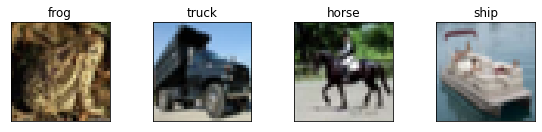

In [103]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# Converting images to numpy arrays to plot
images = images.numpy()

fig = plt.figure(figsize=(25,4))

print(images.shape)

for index in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(2,20/2,index+1,xticks=[], yticks=[])
    imshow(images[index])
    ax.set_title(classes[labels[index]])


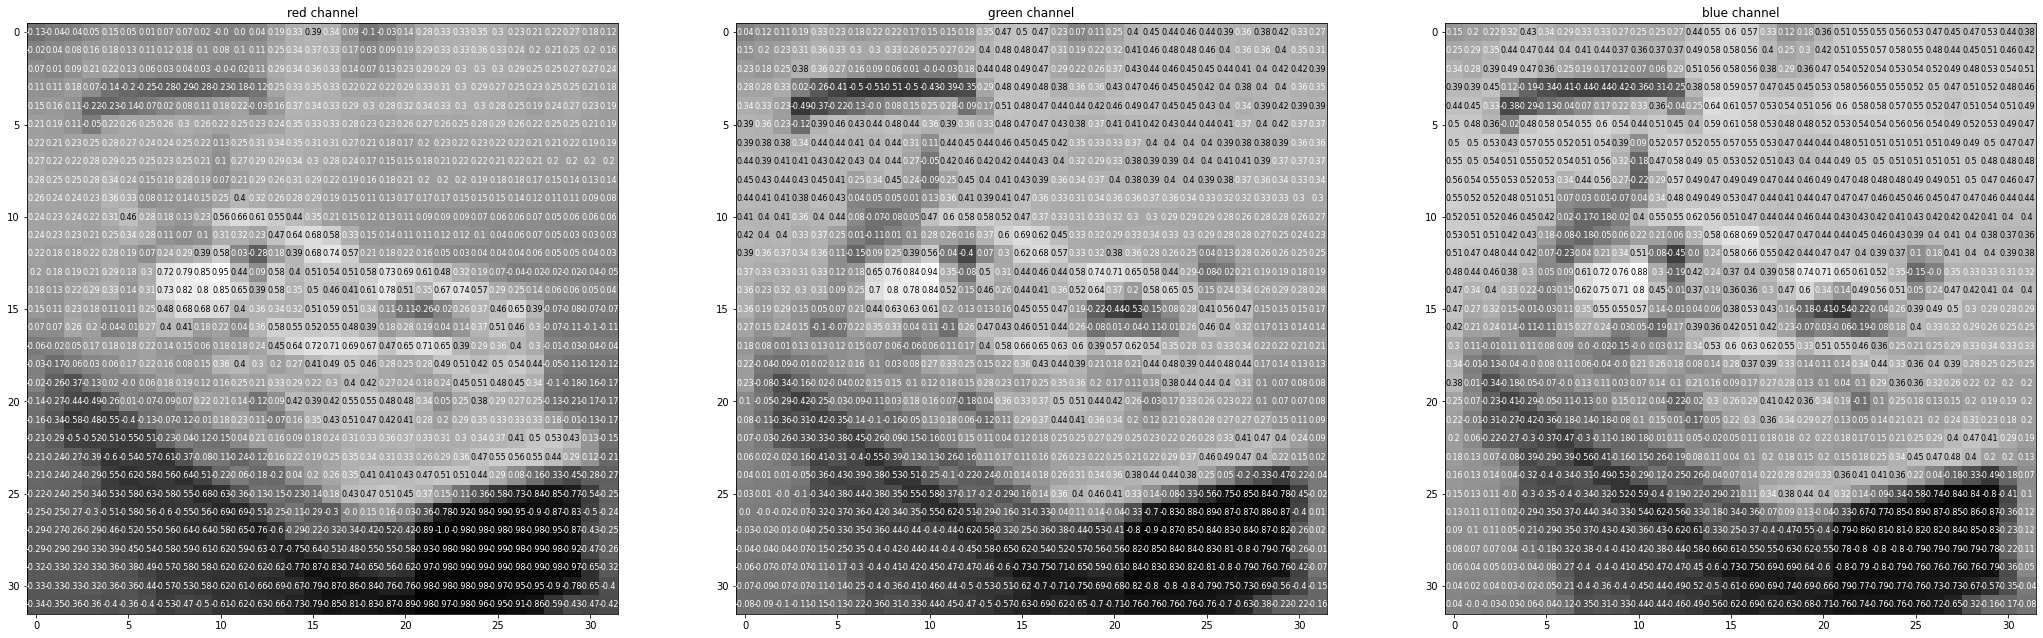

In [104]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize=(36,36))
for index in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, index + 1)
    img = rgb_img[index]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[index])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] != 0 else 0
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        size=8,
                        color='white' if img[x][y]<thresh else 'black')

In [105]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [106]:
import torch.optim as optim
net = Net()
criterion = nn.CrossEntropyLoss()

def closure():
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    return loss

state_dictionaries = {}

def train(opt):
    global inputs, labels
    print('Starting to train with optimizer: ', type(opt).__name__)
    for epoch in range(EPOCHS):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            loss = closure()
            if type(opt).__name__ != "LBFGS":
                opt.step()
            else:
                opt.step(closure)

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    print('Finished Training with optimizer: ', type(opt).__name__)
    state_dictionaries[type(opt).__name__] = net.state_dict()

In [107]:
# Training with SGD Optimizer
optimizers = []
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  SGD
[1,  2000] loss: 2.198
[1,  4000] loss: 1.873
[1,  6000] loss: 1.671
[1,  8000] loss: 1.598
[1, 10000] loss: 1.543
[1, 12000] loss: 1.491
[2,  2000] loss: 1.421
[2,  4000] loss: 1.374
[2,  6000] loss: 1.358
[2,  8000] loss: 1.327
[2, 10000] loss: 1.295
[2, 12000] loss: 1.306
Finished Training with optimizer:  SGD


In [108]:
# Training with Adgrad Optimizer
net = Net()
optimizer = optim.Adagrad(net.parameters(), lr=LR, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adagrad
[1,  2000] loss: 2.099
[1,  4000] loss: 1.957
[1,  6000] loss: 1.932
[1,  8000] loss: 1.898
[1, 10000] loss: 1.885
[1, 12000] loss: 1.875
[2,  2000] loss: 1.859
[2,  4000] loss: 1.846
[2,  6000] loss: 1.842
[2,  8000] loss: 1.807
[2, 10000] loss: 1.809
[2, 12000] loss: 1.809
Finished Training with optimizer:  Adagrad


In [109]:
# Training with Adam Optimizer
net = Net()
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.99))
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adam
[1,  2000] loss: 1.862
[1,  4000] loss: 1.629
[1,  6000] loss: 1.519
[1,  8000] loss: 1.475
[1, 10000] loss: 1.433
[1, 12000] loss: 1.414
[2,  2000] loss: 1.348
[2,  4000] loss: 1.326
[2,  6000] loss: 1.308
[2,  8000] loss: 1.300
[2, 10000] loss: 1.290
[2, 12000] loss: 1.279
Finished Training with optimizer:  Adam


In [110]:
# Training with Adamax Optimizer
net = Net()
optimizer = optim.Adamax(net.parameters(), lr=LR)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Adamax
[1,  2000] loss: 1.902
[1,  4000] loss: 1.691
[1,  6000] loss: 1.608
[1,  8000] loss: 1.549
[1, 10000] loss: 1.530
[1, 12000] loss: 1.497
[2,  2000] loss: 1.426
[2,  4000] loss: 1.391
[2,  6000] loss: 1.368
[2,  8000] loss: 1.335
[2, 10000] loss: 1.313
[2, 12000] loss: 1.299
Finished Training with optimizer:  Adamax


In [111]:
# Training with ASGD Optimizer
net = Net()
optimizer = optim.ASGD(net.parameters(), lr=LR)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  ASGD
[1,  2000] loss: 2.303
[1,  4000] loss: 2.300
[1,  6000] loss: 2.293
[1,  8000] loss: 2.275
[1, 10000] loss: 2.234
[1, 12000] loss: 2.180
[2,  2000] loss: 2.104
[2,  4000] loss: 2.067
[2,  6000] loss: 2.024
[2,  8000] loss: 1.972
[2, 10000] loss: 1.935
[2, 12000] loss: 1.895
Finished Training with optimizer:  ASGD


In [112]:
# Training with LBFGS Optimizer
net = Net()
optimizer = optim.LBFGS(net.parameters(), lr=LR)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  LBFGS
[1,  2000] loss: 2.306
[1,  4000] loss: 2.306
[1,  6000] loss: 2.307
[1,  8000] loss: 2.304
[1, 10000] loss: 2.303
[1, 12000] loss: 2.307
[2,  2000] loss: 2.305
[2,  4000] loss: 2.306
[2,  6000] loss: 2.306
[2,  8000] loss: 2.306
[2, 10000] loss: 2.304
[2, 12000] loss: 2.305
Finished Training with optimizer:  LBFGS


In [113]:
# Training with Rprop Optimizer
net = Net()
optimizer = optim.Rprop(net.parameters(), lr=LR)
train(optimizer)
optimizers.append(optimizer)

Starting to train with optimizer:  Rprop
[1,  2000] loss: 15.137
[1,  4000] loss: 11.616
[1,  6000] loss: 10.304
[1,  8000] loss: 9.812
[1, 10000] loss: 10.006
[1, 12000] loss: 9.631
[2,  2000] loss: 9.326
[2,  4000] loss: 9.536
[2,  6000] loss: 8.876
[2,  8000] loss: 9.830
[2, 10000] loss: 10.658
[2, 12000] loss: 10.887
Finished Training with optimizer:  Rprop


In [117]:
len(state_dictionaries)

7

In [119]:
def getOptimizerStateValues(opt, dict):
    return dict[type(opt).__name__]

def getOptimizerKey(opt):
    return type(opt).__name__

torch.save({
    getOptimizerKey(optimizers[0]): getOptimizerStateValues(optimizers[0], state_dictionaries),
    getOptimizerKey(optimizers[1]): getOptimizerStateValues(optimizers[1], state_dictionaries),
    getOptimizerKey(optimizers[2]): getOptimizerStateValues(optimizers[2], state_dictionaries),
    getOptimizerKey(optimizers[3]): getOptimizerStateValues(optimizers[3], state_dictionaries),
    getOptimizerKey(optimizers[4]): getOptimizerStateValues(optimizers[4], state_dictionaries),
    getOptimizerKey(optimizers[5]): getOptimizerStateValues(optimizers[5], state_dictionaries),
    getOptimizerKey(optimizers[6]): getOptimizerStateValues(optimizers[6], state_dictionaries)
}, PATH)

GroundTruth:    cat  ship  ship plane


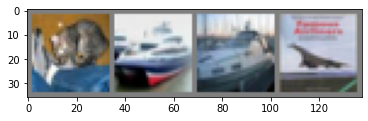

In [120]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Next, let's load back in our saved model (note: saving and re-loading the model
wasn't necessary here, we only did it to illustrate how to do so):



In [121]:
checkpoint = torch.load(PATH)
checkpoint

{'SGD': OrderedDict([('conv1.weight',
               tensor([[[[ 2.4814e-01, -1.2095e-01, -9.0430e-02,  6.6491e-02,  5.7299e-02],
                         [-1.4283e-01, -3.4426e-01, -6.7095e-02,  3.5994e-01,  1.9519e-01],
                         [-1.6313e-01, -4.7893e-01, -1.3388e-01,  3.4985e-01,  2.8293e-01],
                         [ 9.5249e-02, -3.5521e-01, -1.8758e-01,  1.6514e-01,  1.1831e-01],
                         [ 5.3739e-03, -1.8569e-01, -4.9859e-03, -7.1905e-02, -8.5245e-02]],
               
                        [[-6.6691e-02, -1.3172e-01, -7.3198e-02,  2.5532e-02,  7.2812e-03],
                         [-1.7090e-01, -5.0652e-01,  9.3722e-02,  4.6106e-01,  7.6660e-02],
                         [-1.7274e-01, -4.0711e-01, -1.0523e-01,  3.8341e-01,  2.0271e-01],
                         [ 1.5938e-01, -3.6773e-01, -1.4899e-01,  1.6068e-01,  2.4548e-01],
                         [ 2.3639e-01,  1.2672e-02, -1.1863e-01,  1.0901e-01,  8.7353e-02]],
               
        

In [122]:
for optimizer in optimizers:
    net = Net()
    print("Test run for run with optimizer: ", type(optimizer).__name__)
    net.load_state_dict(checkpoint[type(optimizer).__name__])
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(BATCH_SIZE)))

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images for %s Optimizer: %d%%' % (
        type(optimizer).__name__, 100 * correct / total))
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(BATCH_SIZE):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

Test run for run with optimizer:  SGD
Predicted:    cat  ship   car  ship
Accuracy of the network on the 10000 test images for SGD Optimizer: 55%
Accuracy of plane : 53 %
Accuracy of   car : 81 %
Accuracy of  bird : 36 %
Accuracy of   cat : 38 %
Accuracy of  deer : 34 %
Accuracy of   dog : 60 %
Accuracy of  frog : 60 %
Accuracy of horse : 64 %
Accuracy of  ship : 70 %
Accuracy of truck : 55 %
Test run for run with optimizer:  Adagrad
Predicted:    dog   dog   dog horse
Accuracy of the network on the 10000 test images for Adagrad Optimizer: 36%
Accuracy of plane : 51 %
Accuracy of   car : 37 %
Accuracy of  bird : 13 %
Accuracy of   cat : 22 %
Accuracy of  deer : 17 %
Accuracy of   dog : 31 %
Accuracy of  frog : 60 %
Accuracy of horse : 41 %
Accuracy of  ship : 42 %
Accuracy of truck : 48 %
Test run for run with optimizer:  Adam
Predicted:   frog   dog  frog horse
Accuracy of the network on the 10000 test images for Adam Optimizer: 55%
Accuracy of plane : 46 %
Accuracy of   car : 55 %
Ac